## Contest [Link](https://hack.univ.ai/)

In [2]:
import os

BASE_DIR = '/content/drive/MyDrive/Hackerearth/univ_ai'
os.chdir(BASE_DIR)

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Current BottleNeck

One hot encoding of datapoints is creating issues. Not all categorical data points present in train dataset are present in pred dataset and vice versa

#### Get dataset

In [118]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [119]:
df = pd.read_csv(BASE_DIR + '/data/Training Data.csv')

df.head()

,Id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years,risk_flag
0,1,1303835,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [120]:
df = pd.get_dummies(df, columns=[ 'married', 'house_ownership', 'car_ownership', 'profession', 'city', 'state' ])
df.rename(columns={'Id': 'id'})
df.head()

,Id,income,age,experience,current_job_years,current_house_years,risk_flag,married_married,married_single,house_ownership_norent_noown,house_ownership_owned,house_ownership_rented,car_ownership_no,car_ownership_yes,profession_Air_traffic_controller,profession_Analyst,profession_Architect,profession_Army_officer,profession_Artist,profession_Aviator,profession_Biomedical_Engineer,profession_Chartered_Accountant,profession_Chef,profession_Chemical_engineer,profession_Civil_engineer,profession_Civil_servant,profession_Comedian,profession_Computer_hardware_engineer,profession_Computer_operator,profession_Consultant,profession_Dentist,profession_Design_Engineer,profession_Designer,profession_Drafter,profession_Economist,profession_Engineer,profession_Fashion_Designer,profession_Financial_Analyst,profession_Firefighter,profession_Flight_attendant,...,city_Uluberia,city_Unnao,city_Vadodara,city_Varanasi,city_Vasai-Virar,city_Vellore,city_Vijayanagaram,city_Vijayawada,city_Visakhapatnam[4],city_Warangal[11][12],city_Yamunanagar,state_Andhra_Pradesh,state_Assam,state_Bihar,state_Chandigarh,state_Chhattisgarh,state_Delhi,state_Gujarat,state_Haryana,state_Himachal_Pradesh,state_Jammu_and_Kashmir,state_Jharkhand,state_Karnataka,state_Kerala,state_Madhya_Pradesh,state_Maharashtra,state_Manipur,state_Mizoram,state_Odisha,state_Puducherry,state_Punjab,state_Rajasthan,state_Sikkim,state_Tamil_Nadu,state_Telangana,state_Tripura,state_Uttar_Pradesh,state_Uttar_Pradesh[5],state_Uttarakhand,state_West_Bengal
0,1,1303835,23,3,3,13,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,7574516,40,10,9,13,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,3991815,66,4,4,10,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,6256451,41,2,2,12,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,5,5768871,47,11,3,14,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [111]:
import re

_count = 0
def change_name(x):
    global _count
    _count += 1
    return re.sub("[\[].*?[\]]", str(_count), x)

df = df.rename(columns=change_name)

In [ ]:
from collections import Counter
Counter(df.columns)

In [42]:
'risk_flag' in df.columns

True

In [81]:
train_df, test_df = train_test_split(df, train_size=0.8, stratify = df['risk_flag'])

In [82]:
train_df.head()

,Id,income,age,experience,current_job_years,current_house_years,risk_flag,married_married,married_single,house_ownership_norent_noown,house_ownership_owned,house_ownership_rented,car_ownership_no,car_ownership_yes,profession_Air_traffic_controller,profession_Analyst,profession_Architect,profession_Army_officer,profession_Artist,profession_Aviator,profession_Biomedical_Engineer,profession_Chartered_Accountant,profession_Chef,profession_Chemical_engineer,profession_Civil_engineer,profession_Civil_servant,profession_Comedian,profession_Computer_hardware_engineer,profession_Computer_operator,profession_Consultant,profession_Dentist,profession_Design_Engineer,profession_Designer,profession_Drafter,profession_Economist,profession_Engineer,profession_Fashion_Designer,profession_Financial_Analyst,profession_Firefighter,profession_Flight_attendant,...,city_Uluberia,city_Unnao,city_Vadodara,city_Varanasi,city_Vasai-Virar,city_Vellore,city_Vijayanagaram,city_Vijayawada,city_Visakhapatnam4,city_Warangal1112,city_Yamunanagar,state_Andhra_Pradesh,state_Assam,state_Bihar,state_Chandigarh,state_Chhattisgarh,state_Delhi,state_Gujarat,state_Haryana,state_Himachal_Pradesh,state_Jammu_and_Kashmir,state_Jharkhand,state_Karnataka,state_Kerala,state_Madhya_Pradesh,state_Maharashtra,state_Manipur,state_Mizoram,state_Odisha,state_Puducherry,state_Punjab,state_Rajasthan,state_Sikkim,state_Tamil_Nadu,state_Telangana,state_Tripura,state_Uttar_Pradesh,state_Uttar_Pradesh5,state_Uttarakhand,state_West_Bengal
27228,27229,7020077,63,9,9,13,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28508,28509,2568258,67,5,5,11,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
84875,84876,5358407,22,3,3,10,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
122593,122594,4492240,69,16,8,13,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
161037,161038,2807047,39,12,5,11,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [83]:
# same num of +ve and -ve class for training
train_df = train_df.groupby('risk_flag', group_keys=False).apply(lambda x: x.sample(min(len(x), 24000)))

x_train, y_train = train_df.drop('risk_flag', axis=1), train_df['risk_flag']
x_val, y_val = test_df.drop('risk_flag', axis=1), test_df['risk_flag']

In [84]:
print(y_train.value_counts(), y_val.value_counts(), sep='\n')

1    24000
0    24000
Name: risk_flag, dtype: int64
0    44201
1     6199
Name: risk_flag, dtype: int64


In [94]:
neg, pos = y_train.value_counts()
scale_pos_weigh = neg / pos
print(f'scale_pos_weigh: {scale_pos_weigh},  Neg% : {neg / (neg + pos)}')

scale_pos_weigh: 1.0,  Neg% : 0.5


### Model

In [10]:
import xgboost as xgb

In [87]:
clf = xgb.XGBClassifier(scale_pos_weigh=scale_pos_weigh)

clf.fit(x_train, y_train, verbose=True, early_stopping_rounds=20, eval_metric='aucpr', eval_set=[(x_val, y_val)])

[0]	validation_0-aucpr:0.170911
Will train until validation_0-aucpr hasn't improved in 20 rounds.
[1]	validation_0-aucpr:0.170814
[2]	validation_0-aucpr:0.170845
[3]	validation_0-aucpr:0.170958
[4]	validation_0-aucpr:0.170599
[5]	validation_0-aucpr:0.171223
[6]	validation_0-aucpr:0.172351
[7]	validation_0-aucpr:0.17344
[8]	validation_0-aucpr:0.173354
[9]	validation_0-aucpr:0.173244
[10]	validation_0-aucpr:0.175796
[11]	validation_0-aucpr:0.178326
[12]	validation_0-aucpr:0.177678
[13]	validation_0-aucpr:0.179036
[14]	validation_0-aucpr:0.180727
[15]	validation_0-aucpr:0.181113
[16]	validation_0-aucpr:0.182978
[17]	validation_0-aucpr:0.183412
[18]	validation_0-aucpr:0.183043
[19]	validation_0-aucpr:0.183881
[20]	validation_0-aucpr:0.184426
[21]	validation_0-aucpr:0.184823
[22]	validation_0-aucpr:0.185515
[23]	validation_0-aucpr:0.18601
[24]	validation_0-aucpr:0.186929
[25]	validation_0-aucpr:0.187408
[26]	validation_0-aucpr:0.187824
[27]	validation_0-aucpr:0.188325
[28]	validation_0-aucp

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weigh=1.0,
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              verbosity=1)

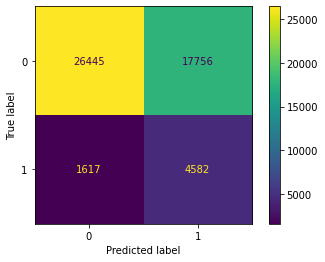

In [89]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score

plot_confusion_matrix(clf, x_val, y_val, values_format='d')

In [91]:
accuracy_score(y_val, clf.predict(x_val))

0.6156150793650793

### Predict

In [113]:
pred_df = pd.read_csv(BASE_DIR + '/data/Test Data.csv')
pred_df.head()

,id,income,age,experience,married,house_ownership,car_ownership,profession,city,state,current_job_years,current_house_years
0,1,7393090,59,19,single,rented,no,Geologist,Malda,West Bengal,4,13
1,2,1215004,25,5,single,rented,no,Firefighter,Jalna,Maharashtra,5,10
2,3,8901342,50,12,single,rented,no,Lawyer,Thane,Maharashtra,9,14
3,4,1944421,49,9,married,rented,yes,Analyst,Latur,Maharashtra,3,12
4,5,13429,25,18,single,rented,yes,Comedian,Berhampore,West Bengal,13,11


In [114]:
pred_df = pd.get_dummies(pred_df, columns=[ 'married', 'house_ownership', 'car_ownership', 'profession', 'city', 'state' ])

_count = 0
pred_df = pred_df.rename(columns=change_name)
pred_df.head()

,id,income,age,experience,current_job_years,current_house_years,married_married,married_single,house_ownership_norent_noown,house_ownership_owned,house_ownership_rented,car_ownership_no,car_ownership_yes,profession_Air traffic controller,profession_Analyst,profession_Architect,profession_Army officer,profession_Artist,profession_Aviator,profession_Biomedical Engineer,profession_Chartered Accountant,profession_Chef,profession_Chemical engineer,profession_Civil engineer,profession_Civil servant,profession_Comedian,profession_Computer hardware engineer,profession_Computer operator,profession_Consultant,profession_Dentist,profession_Design Engineer,profession_Designer,profession_Drafter,profession_Economist,profession_Engineer,profession_Fashion Designer,profession_Financial Analyst,profession_Firefighter,profession_Flight attendant,profession_Geologist,...,city_Uluberia,city_Unnao,city_Vadodara,city_Varanasi,city_Vasai-Virar,city_Vellore,city_Vijayanagaram,city_Vijayawada,city_Visakhapatnam379,city_Warangal380380,city_Yamunanagar,state_Andhra Pradesh,state_Assam,state_Bihar,state_Chandigarh,state_Chhattisgarh,state_Delhi,state_Gujarat,state_Haryana,state_Himachal Pradesh,state_Jammu and Kashmir,state_Jharkhand,state_Karnataka,state_Kerala,state_Madhya Pradesh,state_Maharashtra,state_Manipur,state_Mizoram,state_Odisha,state_Puducherry,state_Punjab,state_Rajasthan,state_Sikkim,state_Tamil Nadu,state_Telangana,state_Tripura,state_Uttar Pradesh,state_Uttar Pradesh408,state_Uttarakhand,state_West Bengal
0,1,7393090,59,19,4,13,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1215004,25,5,5,10,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,8901342,50,12,9,14,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1944421,49,9,3,12,1,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,13429,25,18,13,11,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [116]:
set(pred_df.columns) - set(df.columns)

{'city_Anantapuram86',
 'city_Aurangabad90',
 'city_Bettiah106',
 'city_Bhalswa Jahangir Pur',
 'city_Bihar Sharif',
 'city_Buxar131',
 'city_Chittoor137',
 'city_Dehri144',
 'city_Eluru155',
 'city_Erode156',
 'city_Guntur174',
 'city_Hajipur178',
 'city_Jamalpur197',
 'city_Jammu198',
 'city_Jehanabad202',
 'city_Kadapa207',
 'city_Karawal Nagar',
 'city_Khora, Ghaziabad',
 'city_Kirari Suleman Nagar',
 'city_Kishanganj224',
 'city_Kota230',
 'city_Kurnool235',
 'city_Motihari261',
 'city_Mysore266266266',
 'city_Nangloi Jat',
 'city_Navi Mumbai',
 'city_Nellore278278',
 'city_New Delhi',
 'city_North Dumdum',
 'city_Purnia302',
 'city_Rajahmundry307307',
 'city_Rajpur Sonarpur',
 'city_Ramagundam310',
 'city_Raurkela Industrial Township',
 'city_Saharsa321',
 'city_Sangli-Miraj & Kupwad',
 'city_Sasaram326',
 'city_Siwan340',
 'city_South Dumdum',
 'city_Sri Ganganagar',
 'city_Sultan Pur Majra',
 'city_Surendranagar Dudhrej',
 'city_Tiruchirappalli361',
 'city_Tirupati363363',
 'ci

In [115]:
predict = pd.DataFrame({
    'id': pred_df['id'],
    'risk_flag': clf.predict(pred_df)
})

predict.head()

ValueError: ignored